In [3]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [10]:
!mkdir data
!tar -xf "drive/MyDrive/inno_stats.tar.gz" -C ./data

mkdir: cannot create directory ‘data’: File exists


In [4]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  10_groups.csv  11_groups.csv  bad_ids.csv  product_groups.csv


In [5]:
df = pd.read_csv('./data/09_groups.csv')
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [6]:
df.shape

(42100858, 10)

In [7]:
bad_ids = pd.read_csv('./data/bad_ids.csv')
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [8]:
df = df[~df['id_card'].isin(bad_ids['id_card'].values)]
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [16]:
df.shape

(38466003, 10)

In [11]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

In [12]:
from scipy.stats import ttest_ind

In [13]:
df['is_green'] = df['is_green'].astype(bool)

In [14]:
disc_docs = df[df['is_green']].groupby(['id_doc']).sum()
disc_docs.head()

,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
id_doc,,,,,,,,
19,0.0,2845203,66378,29752,3.0,165.0,3,30206
60,0.0,82961,33233,12936,1.0,54.6,1,10037
76,0.0,534316,22449,11994,1.0,114.6,1,10043
138,0.0,3083781,519,46155,3.0,93.0,3,30273
152,0.0,3250490,44797,12236,2.0,99.6,2,20203


In [15]:
disc_docs = disc_docs['sum']

In [17]:
nondisc_docs = df[~df['is_green']].sample(len(disc_docs)).groupby(['id_doc']).sum()['sum']

In [18]:
nondisc_docs

id_doc
50          565.35
66          204.00
85           92.00
102         105.00
117          29.00
             ...  
23417720     68.00
23417727     45.00
23417771    100.00
23417788     63.00
23417853    258.20
Name: sum, Length: 940947, dtype: float64

In [20]:
ttest_ind(disc_docs, nondisc_docs)

Ttest_indResult(statistic=224.46282541603176, pvalue=0.0)

In [16]:
disc_docs.mean()

190.68263650300798

In [19]:
nondisc_docs.mean()

134.34779551875218

P-value is 0, so null hypothesis is rejected. We also see that the average for discounted checks is greater than the average for non-discounted checks.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [11]:
import matplotlib.pyplot as plt

In [22]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,False,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,False,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,False,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,False,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,False,10091


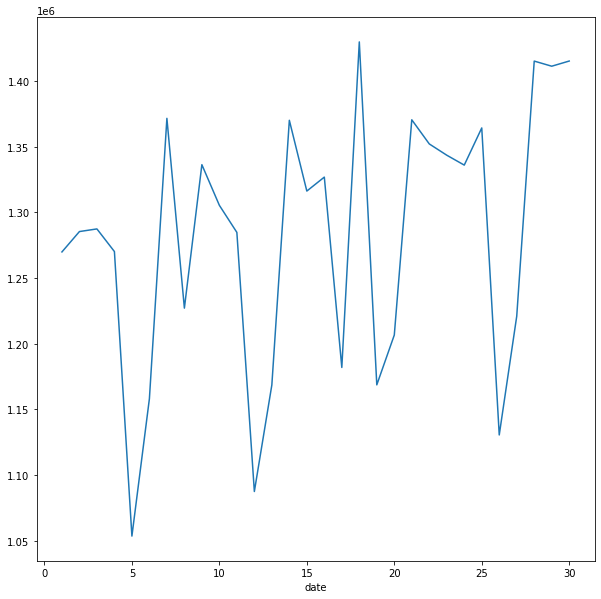

In [23]:
plt.figure(figsize=(10,10))
df.groupby(df['date'].dt.day)['id_order'].count().plot()

The graph shows an increase in the number of purchases starting from the first and twentieth days of the month, but we also see an increase in the number of purchases on other days. And these peaks appear with a frequency of 7 days, so there is a dependence of the number of purchases on the day of the week, but there is no dependence between the wage days and the number of purchases.

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea


Frequent buyers

In [9]:
customs = df.groupby(by=['id_card'])
customs.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
42100846,2020-09-30 12:48:53,6200411,0.0,1432778,22639,12970,1.0,188.00,0,10098
42100851,2020-09-30 08:36:05,21205108,0.0,500292,25023,16304,1.0,140.00,0,10196
42100855,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254
42100856,2020-09-30 12:00:04,1648929,0.0,484390,34835,15916,1.0,78.00,0,10099



Average purchase sum

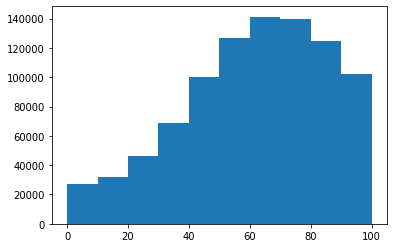

In [12]:
df_aver = df.groupby('id_card')['sum'].std()
df_aver = df_aver[df_aver  < 100]

plt.hist(df_aver);

Orders amount

In [13]:
customs = df.groupby(by=['id_card']).agg({"id_doc": "nunique"})
customs = customs.groupby(by=['id_doc'])
customs.head()

,id_doc
id_card,
0,10
1,1
2,1
3,9
4,5
...,...
1609030,73
1789392,98
1808366,103


Usual cart

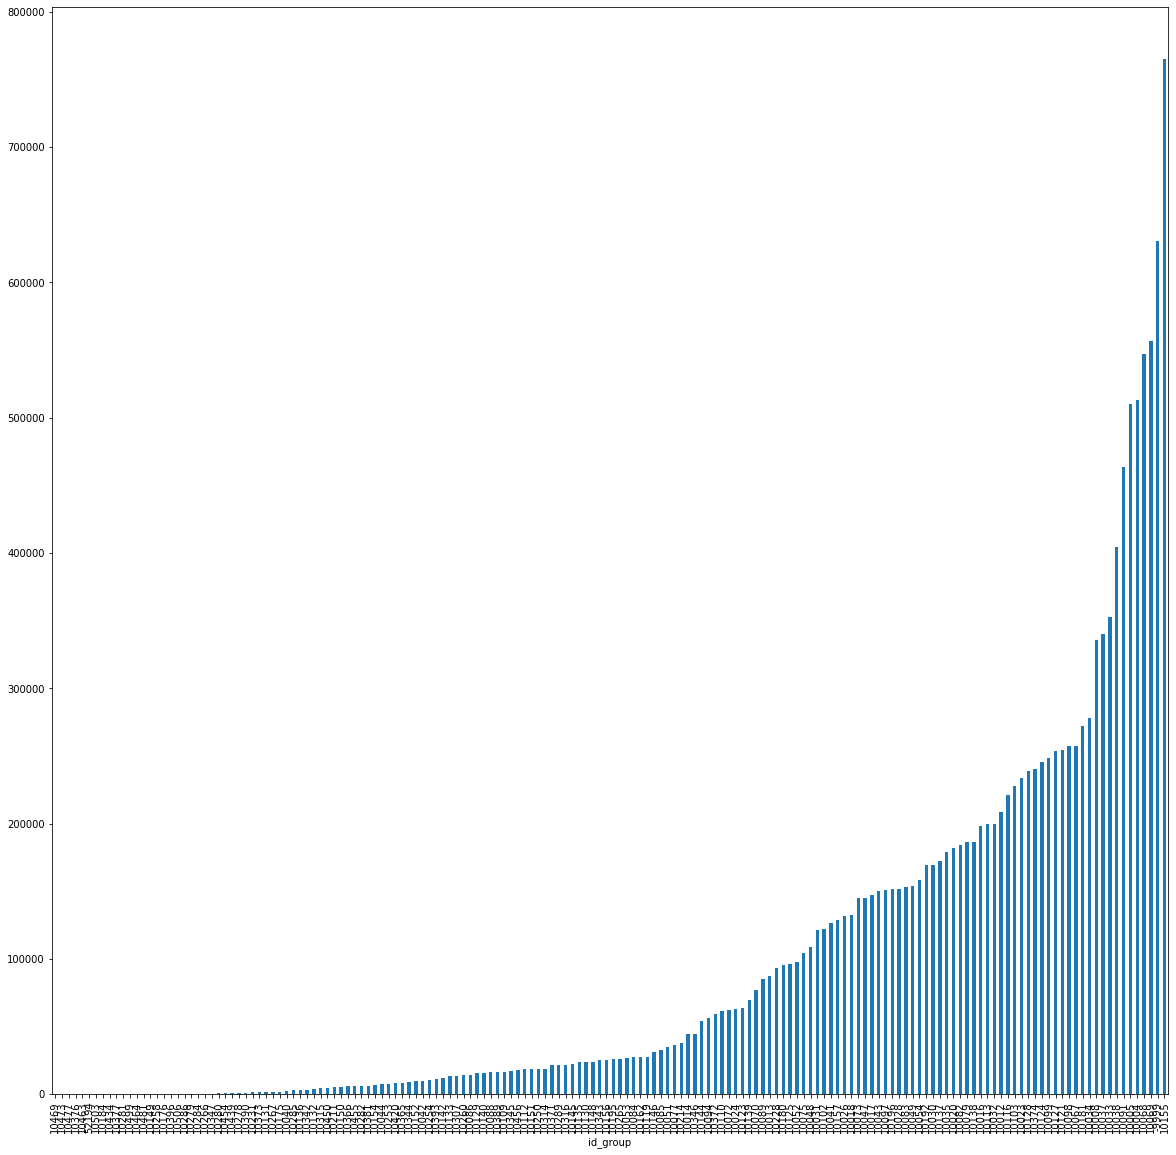

In [17]:
customs = df.groupby(by=['id_group'])['id_card'].unique().apply(len)
plt.figure(figsize=(20, 20))
customs.sort_values().plot(kind='bar')